In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import json

In [2]:
merchants = pd.read_csv("./data/modified_merchants.csv")
merchants.head(5)

,Unnamed: 0,service_id,store_id,service_group,merchant_name,merchant_address,store_name,store_address,store_longitude,store_latitude,unique_id,modified_service
0,0,1058241667815469540,249887925492461203,other,CÔNG TY CP TMDV TVTK THỜI TRANG VIỆT,"189A Hai Bà Trưng , P.6, Quận 3 TPHCM",Concept Nguyễn Trãi Cần Thơ,"41-41A-43 Nguyễn Trãi, Q. Ninh Kiều, Cần Thơ",105.785046,10.040508,1058241667815469540-249887925492461203,1058241667815469540
1,1,1058241667815469540,6272474026035536581,other,CÔNG TY CP TMDV TVTK THỜI TRANG VIỆT,"189A Hai Bà Trưng , P.6, Quận 3 TPHCM",Concept Hậu Giang,"Số 410 Hậu Giang, Phường 12, Quận 6, Tp. HCM",106.638935,10.749251,1058241667815469540-6272474026035536581,1058241667815469540
2,2,8073873840719601655,2217087971996193230,beverage,HỘ KINH DOANH - QUÁCH THỊ HƯƠNG DUYÊN,"444 Hoàng Văn Thụ, Phường 2, Quận Tân Bình, Th...",Sharetea Hoàng Văn Thụ,"444 Hoàng Văn Thụ, Phường 4, Quận Tân Bình, Th...",106.655742,10.795501,8073873840719601655-2217087971996193230,8073873840719601655
3,3,1058241667815469540,7296552596579579660,other,CÔNG TY CP TMDV TVTK THỜI TRANG VIỆT,"189A Hai Bà Trưng , P.6, Quận 3 TPHCM",Concept Cách Mạng tháng 8 HCM,"Số 484 - 486 Cách Mạng Tháng Tám, Phường 11, Q...",106.668518,10.784919,1058241667815469540-7296552596579579660,1058241667815469540
4,4,1058241667815469540,4707467693322385152,other,CÔNG TY CP TMDV TVTK THỜI TRANG VIỆT,"189A Hai Bà Trưng , P.6, Quận 3 TPHCM",Concept Vạnh Hạnh Mall,"TTTM,Số 11 Sư Vạn Hạnh, Đường 3/2, Phường 12, ...",106.669971,10.769976,1058241667815469540-4707467693322385152,1058241667815469540


In [3]:
transactions = pd.read_csv('./data/transactions2train.csv')
transactions.sample(5)

,Unnamed: 0,user_id,service_id,amount,visit_count,total_amount,favor,avr_amount,rating,service_group,user_code,service_code
492122,492122,8265186880058794754,7398373044743834494,138000,1,2115000,0.065248,193000.0,0,fnb,98219,438
8441,8441,1122333328282270033,946180032524845328,48000,1,5265000,0.009117,127000.0,0,other,1687,548
447896,447896,7612593501318639968,3615982237552954784,326000,1,910000,0.358242,125000.0,1,beverage,89441,169
454198,454198,7706235167287609033,2444871135670595807,1318000,6,2491000,0.529105,227000.0,1,other,90698,96
462529,462529,7828901565504566083,9053682795303467962,232000,1,2621000,0.088516,196000.0,1,fnb,92361,531


In [4]:
total_amount = transactions.groupby('service_id', as_index = False)['amount'].mean()
total_visit = transactions.groupby('service_id', as_index = False)['visit_count'].sum()



In [5]:
result = pd.concat([total_amount, total_visit], axis=1, sort=False)
result = result.loc[:,~result.columns.duplicated()]


In [6]:
result['amount'] = result['amount'] / 1000



In [7]:
result.head()

,service_id,amount,visit_count
0,100459171840484639,394.821380,1088
1,100670421557790535,455.711584,554
2,1011115523130927864,315.156684,3427
3,1020517967048203191,428.581081,1095
4,1023280480942069518,413.481405,667


In [8]:
result.describe()

,amount,visit_count
count,549.000000,549.000000
mean,395.837612,1449.825137
std,125.085164,1636.403466
min,1.000000,1.000000
25%,399.689861,802.000000
50%,424.482543,1242.000000
75%,443.167647,1725.000000
max,1382.500000,19408.000000


### Weight Rating Formular
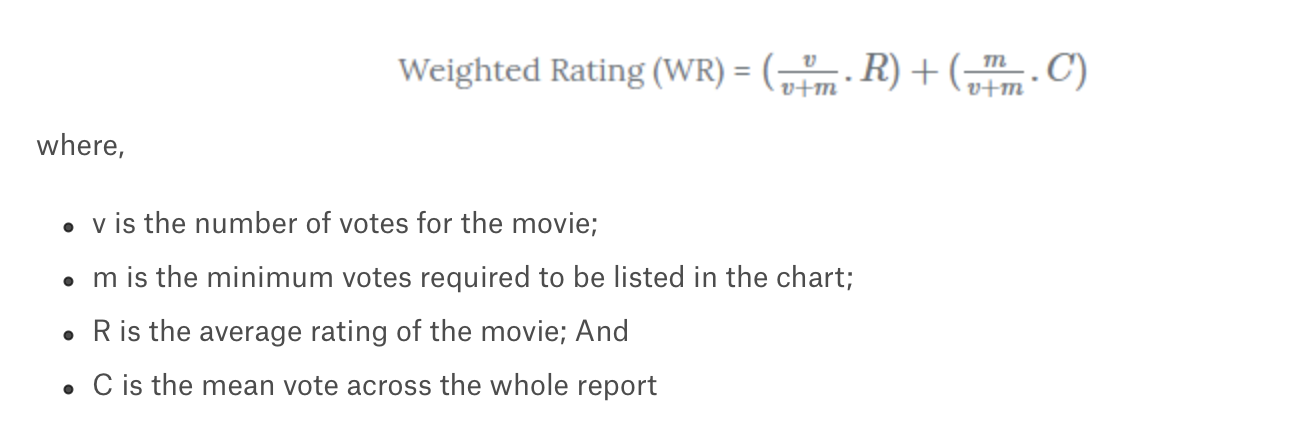


### Custom Weight Rating Formula: 
- v: number of total visit of service
- m: minimum visit (500)
- R: mean (total amount) of service
- C: mean of total visit of all service

In [9]:
total_visits = result['visit_count'].sum()
total_services = result['visit_count'].nunique()
C = total_visits / total_services
C

1846.7610208816704

In [10]:
def calculate_weight_rating (v, R):
    m = 500
    C = total_visits / total_services
    score = ((v / (v + m))*R ) + ((m / (v + m)) * C)
    return score

In [11]:
result['score'] = result.apply(lambda x: calculate_weight_rating(x['visit_count'], x['amount']), axis=1)

In [12]:
result.sort_values(by = 'score').head(5)

,service_id,amount,visit_count,score
435,7341550893129842017,190.355147,18855,233.145275
318,5654538597012118714,229.768862,7264,333.902824
397,6867086828130189483,268.835966,5396,402.649149
177,3771801775643244829,262.253061,5136,402.823320
169,3615982237552954784,289.336152,6319,403.533605


In [13]:
result_list = result[['service_id','score']].sort_values(by = 'score')
result_list = result_list.rename({'service_id': 'serviceId'}, axis = 1)
result_list



,serviceId,score
435,7341550893129842017,233.145275
318,5654538597012118714,333.902824
397,6867086828130189483,402.649149
177,3771801775643244829,402.823320
169,3615982237552954784,403.533605
394,6833267496949447871,415.933913
84,2180187955578894951,441.419914
537,9105773273715501159,443.565417
151,3398611740160718989,447.890913
502,8421950360944077064,450.156235


In [14]:
#Export and convert to json file
result_list = result_list.to_json('./json/top_services.txt',orient='records')

